<a href="https://colab.research.google.com/github/martinpdab/asapa/blob/main/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sklearn

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import  train_test_split
from keras.utils.np_utils import to_categorical

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [3]:
URL = 'https://raw.githubusercontent.com/martinpdab/asapa/main/dataset/dataset-kasus-shuffled%20(1).csv'
df = pd.read_csv(URL)
df.head()

,tempat,jenis,banyak_kekerasan,banyak_korban,usia,hubungan_pelaku,label
0,rumah-tangga,seksual,1,1,remaja,orang-tua,2
1,fasilitas-umum,seksual,1,1,dewasa,lainnya,1
2,rumah-tangga,penelantaran,1,1,balita,keluarga/saudara,2
3,rumah-tangga,psikis,1,1,remaja,orang-tua,0
4,rumah-tangga,fisik,1,1,remaja,orang-tua,2


In [10]:
train, test = train_test_split(df, test_size=0.1)
print(len(train), 'train examples')
print(len(test), 'test examples')

4697 train examples
522 test examples


In [9]:
df['target'] = np.where(df['label']==2, 1, 0)

# Drop un-used columns.
df = df.drop(columns=['label'])

df.tail()

,tempat,jenis,banyak_kekerasan,banyak_korban,usia,hubungan_pelaku,target
5214,rumah-tangga,seksual,1,1,dewasa,majikan,1
5215,rumah-tangga,psikis,1,1,dewasa,keluarga/saudara,0
5216,fasilitas-umum,lainnya,1,1,balita,keluarga/saudara,1
5217,rumah-tangga,psikis,1,1,dewasa,tetangga,0
5218,rumah-tangga,fisik,1,1,balita,orang-tua,1


In [11]:
def df_to_dataset(dataframe, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  ds = ds.batch(batch_size)
  return ds

In [12]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
test_ds = df_to_dataset(test, batch_size=batch_size)

In [14]:
for feature_batch, label_batch in train_ds.take(1):
  print('Parameter:', list(feature_batch.keys()))
  print('Tempat Kejadian:', feature_batch['tempat'])
  print('Jenis Kekerasan:', feature_batch['jenis'])
  print('Banyak Kekerasan:', feature_batch['banyak_kekerasan'])
  print('Banyak Korban:', feature_batch['banyak_korban'])
  print('Usia Korban:', feature_batch['usia'])
  print('Hubungan Pelaku dengan Korban:', feature_batch['hubungan_pelaku'])
  print('Label:', label_batch )

Parameter: ['tempat', 'jenis', 'banyak_kekerasan', 'banyak_korban', 'usia', 'hubungan_pelaku']
Tempat Kejadian: tf.Tensor(
[b'rumah-tangga' b'rumah-tangga' b'rumah-tangga' b'rumah-tangga'
 b'lainnya'], shape=(5,), dtype=string)
Jenis Kekerasan: tf.Tensor([b'fisik' b'seksual' b'psikis' b'seksual' b'psikis'], shape=(5,), dtype=string)
Banyak Kekerasan: tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)
Banyak Korban: tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)
Usia Korban: tf.Tensor([b'balita' b'dewasa' b'balita' b'anak-anak' b'dewasa'], shape=(5,), dtype=string)
Hubungan Pelaku dengan Korban: tf.Tensor(
[b'keluarga/saudara' b'suami/istri' b'orang-tua' b'lainnya'
 b'keluarga/saudara'], shape=(5,), dtype=string)
Label: tf.Tensor([1 0 0 1 0], shape=(5,), dtype=int64)


In [22]:
feature_columns = []

feature_columns.append(feature_column.numeric_column('banyak_korban'))
banyak_kekerasan = feature_column.numeric_column('banyak_kekerasan')
feature_columns.append(banyak_kekerasan)

tempat_kejadian = tf.feature_column.categorical_column_with_vocabulary_list(
                'tempat', ['rumah-tangga', 'tempat-kerja', 'sekolah', 'fasilitas-umum', 'lainnya'])
tempat_one_hot = tf.feature_column.indicator_column(tempat_kejadian)
feature_columns.append(tempat_one_hot)

jenis_kekerasan = tf.feature_column.categorical_column_with_vocabulary_list(
    'jenis', ['fisik', 'seksual', 'psikis', 'penelantaran', 'lainnya', 'eksploitasi', 'traficking'])
jenis_one_hot = tf.feature_column.indicator_column(jenis_kekerasan)
feature_columns.append(jenis_one_hot)

usia_korban = tf.feature_column.categorical_column_with_vocabulary_list(
    'usia', ['balita', 'anak-anak', 'remaja', 'dewasa', 'lansia'])
usia_one_hot = tf.feature_column.indicator_column(usia_korban)
feature_columns.append(usia_one_hot)

hubungan_pelaku = tf.feature_column.categorical_column_with_vocabulary_list(
    'hubungan_pelaku', ['orang-tua', 'keluarga/saudara', 'tetangga', 'suami/istri', 'majikan', 'rekan-kerja', 'guru', 'pacar/teman', 'lainnya'])
hubungan_one_hot = tf.feature_column.indicator_column(hubungan_pelaku)
feature_columns.append(hubungan_one_hot)



feature_columns

[NumericColumn(key='banyak_korban', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='banyak_kekerasan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='tempat', vocabulary_list=('rumah-tangga', 'tempat-kerja', 'sekolah', 'fasilitas-umum', 'lainnya'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='jenis', vocabulary_list=('fisik', 'seksual', 'psikis', 'penelantaran', 'lainnya', 'eksploitasi', 'traficking'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='usia', vocabulary_list=('balita', 'anak-anak', 'remaja', 'dewasa', 'lansia'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='hubungan_pelaku', vocabulary_list=

In [23]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
feature_layer

In [18]:
print(df['target'])

0       1
1       0
2       1
3       0
4       1
       ..
5214    1
5215    0
5216    1
5217    0
5218    1
Name: target, Length: 5219, dtype: int64


In [20]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
test_ds = df_to_dataset(test, batch_size=batch_size)

In [29]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy') > 0.99):
                print("\nReached 99% accuracy so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [31]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

johnjjt = model.fit(train_ds,
                  validation_data=test_ds,
                  callbacks = [callbacks],
                  epochs=25)

Epoch 1/25
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
139/147 [===========================>..] - ETA: 0s - loss: 0.3555 - accuracy: 0.8222WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'tempat': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=string>, 'jenis': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'banyak_kekerasan': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'banyak_korban': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=int64>, 'usia': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'hubungan_pelaku': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>}
Consider rewriting this model with the Functional API.
147/147 [==============================] - 1s 5ms/step - loss: 0.3460 - accuracy: 0.8295 - val_loss: 0.1508 - val_accuracy: 0.9636
Epoch 2/25
147/147 [============================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


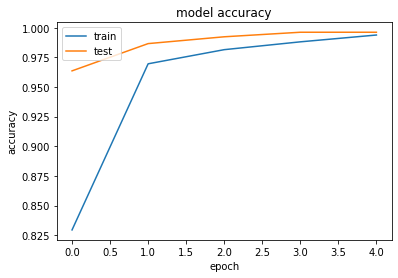

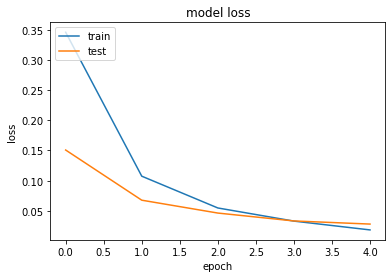

In [33]:
import matplotlib.pyplot as plt
import numpy

print(johnjjt.history.keys())
# summarize history for accuracy
plt.plot(johnjjt.history['accuracy'])
plt.plot(johnjjt.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(johnjjt.history['loss'])
plt.plot(johnjjt.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

17/17 [==============================] - 0s 3ms/step - loss: 0.0281 - accuracy: 0.9962
Accuracy 0.9961685538291931


In [ ]:
model.predict()